# Capstone Project 1: In-Depth Analysis

Data source: https://www.yelp.com/dataset.

In this exploration of the yelp dataset, we will create models that learn about and predict upon the success and failure of yelp restaurants. Is there some restaurant feature that can be used to reliably predict whether a restaurant is out of business? If so, both future restaurateurs and their financial sponsors can benefit from knowing the business impacts of these features. 

We will start by evaluating feature correlations and selecting the features to be used in machine learning analysis. Next, we will extract and integrate the features that are most impactful on the variances in restaurant closure using principal component analysis. Using these principal components, we will then produce and refine a function that predicts whether a restaurant is closed permanently or still open for business using an ensemble of machine learning classifiers from scikit-learn. Along the way, we deal with problems like class imbalance using a sampling strategy and 

1. Principal Component Analysis
2. Benchmarking


In [30]:
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import warnings
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import scale, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import make_scorer
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
sns.set_style("whitegrid")
sns.set_context("poster")

InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")

%store -r rests

SEED = 123

### 1. Feature Selection

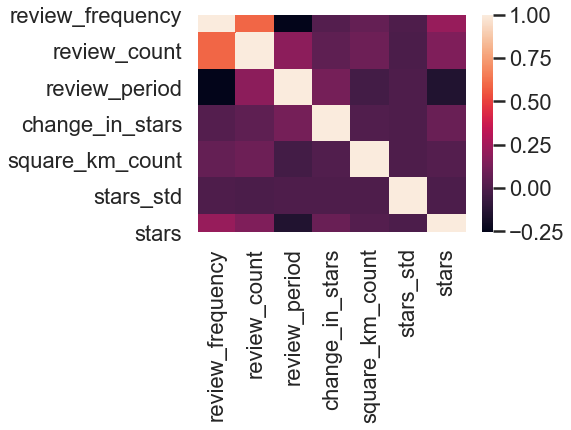

In [3]:
# Evaluate for correlation between features by visualizing them in a correlation heatmap
features = pd.DataFrame(data={'review_frequency': rests['review_frequency'],
                              'review_count': rests['review_count'],
                              'review_period': rests['review_period'],
                              'change_in_stars': rests['change_in_stars'],
                              'square_km_count': rests['square_km_count'],
                              'stars_std': rests['stars_std'],
                              'stars': rests['stars']
                             })
corr = features.corr()
sns.heatmap(corr);

In [4]:
# Evaluate the correlation matrix to check for correlations above 0.9
corr

,review_frequency,review_count,review_period,change_in_stars,square_km_count,stars_std,stars
review_frequency,1.000000,0.594150,-0.255428,0.021573,0.070625,-0.000367,0.217448
review_count,0.594150,1.000000,0.190638,0.052470,0.094561,-0.005605,0.149699
review_period,-0.255428,0.190638,1.000000,0.117582,-0.032796,-0.000034,-0.147337
change_in_stars,0.021573,0.052470,0.117582,1.000000,0.013441,0.003543,0.083726
square_km_count,0.070625,0.094561,-0.032796,0.013441,1.000000,0.003617,0.021176
stars_std,-0.000367,-0.005605,-0.000034,0.003543,0.003617,1.000000,-0.002393
stars,0.217448,0.149699,-0.147337,0.083726,0.021176,-0.002393,1.000000


The correlation heatmap of the features shows that none of the featuers are highly correlated.

### 2. Principal Component Analysis
By performing principal component analysis on the continuous features of the dataset, the dimensions of the dataset will be reduced from 7 to 2. This allows us to visualize how the labels are distributed along the axes of the features. It also helps to speed up the process of in depth machine learning analysis.

In [5]:
# Extract the continuous features from dataframe and scale them to normal distribution
X = scale(rests[['review_count', 'review_period', 'review_frequency',
       'change_in_stars', 'square_km_count', 'stars_std', 'stars']].values)

# Instantiate and perform principal component analysis to reduce the dimension from 7 to 2
pca = PCA(n_components=2)
pc = pca.fit_transform(X)

# Print the explained variance ratio
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.24749254 0.17461273]


Principal component 1 holds 25% of the information while principal component 2 holds 17% of the information, and approximately 58% of the information was lost while projecting 7 dimensional data into 2 dimensional data. Let's visualize the data along the axes of the 2 principal components to see how the sample is distributed among them.

In [6]:
# Create dataframe with the principal components and the categorical feature of interest
ml = pd.DataFrame(data=pc, columns=['pc1','pc2'])
ml['special_category'] = rests['special_category']

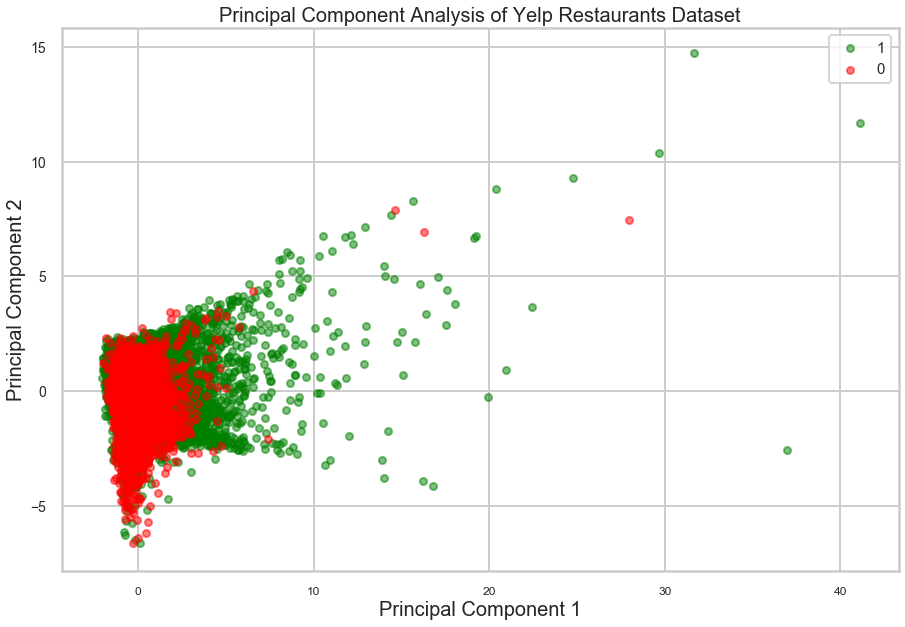

In [7]:
plt.figure(figsize=(15,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.title("Principal Component Analysis of Yelp Restaurants Dataset",fontsize=20)
targets = [1, 0]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = rests['is_open'] == target
    plt.scatter(ml.loc[indicesToKeep, 'pc1']
               , ml.loc[indicesToKeep, 'pc2'], c = color, s = 50, alpha=0.5)

plt.legend(targets,prop={'size': 15})
plt.show();

In the visualization above, we can observe that the two classes 0 and 1 (closed and open) are not linearly classifiable when projected into 2 dimensional space. We can also see that the dataset has a lot more samples of restaurants that are open (in class 1) than ones that are closed (in class 0). This imbalance in the sample makes it more difficult for models to predict when a restaurant is closed. Next, we will solve this problem by implementing a sampling strategy.

### 3. Sampling Strategy
Before implementing the sampling strategy there are 24014 samples in class 1 and 7690 samples in class 0. After using an over-sampling strategy, there are 24014 in class 1 and 19211 in class 0.

In [8]:
sampling_strategy = 0.8

ros = RandomOverSampler(sampling_strategy=sampling_strategy)
X = ml[['pc1','pc2','special_category']].values
y = rests['is_open'].values
X_res, y_res = ros.fit_resample(X, y)
print('Information of the yelp data set after making it '
      'balanced using a float and an over-sampling method: \n '
      'sampling_strategy={} \n y: {}'
      .format(sampling_strategy, Counter(y_res)))

Information of the yelp data set after making it balanced using a float and an over-sampling method: 
 sampling_strategy=0.8 
 y: Counter({1: 24014, 0: 19211})


### 4. Benchmarking
The dummy classifier provides a baseline model with accuracy score of 0.56 for both training and test data sets.

In [9]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=SEED)

# Baseline model using dummy classifier
baseline = DummyClassifier(strategy='prior')

# Fit to training data
baseline.fit(X_train, y_train)

# Predict on test set
y_pred_base = baseline.predict(X_test)

# Evaluate baseline scores
accuracy_score(y_train, baseline.predict(X_train))
accuracy_score(y_test, y_pred_base)

DummyClassifier(constant=None, random_state=None, strategy='prior')

0.5555739167795882

0.5555212831585441

### 5. Decision Tree
As a future restaurateur or the restaurateur's potential financial sponsor, knowing the factors that can predict business closure can be beneficial to the planning and decision making process in opening a new restaurant. The process of identifying whether a restaurant is open or closed permanently is a classification problem that can be solved by developing a model that learns from a set of training data and then makes predictions on a set of test data.

The first model is built using the decision tree classifier from scikit-learn. The decision tree algorithm is easy to interpret and efficient to run. First, we use GridSearchCV to tune the parameters in a decision tree classifier and obtain the optimal classifier. Second, we fit the optimal model to training data so that it learns how to best predict restaurant closure, and then predict on test data to obtain the results.

In [31]:
# Tune hyperparameters in decision tree classifier using GridSearchCV
# Setup the parameters and distributions to sample from: param_grid
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
param_grid = {"max_depth": [2, 3, 5, 7],
              "max_features": [1,2,3],
              "min_samples_leaf": [1,2],
              "criterion": ["gini", "entropy"]}

# Instantiate the GridSearchCV object
grid_cv = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring=scoring, cv=5, refit='AUC', return_train_score=True)

# Fit to training data
grid_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(grid_cv.best_params_))
print("Best score is {}".format(grid_cv.best_score_))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 7], 'max_features': [1, 2, 3]

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 2}
Best score is 0.7016482258084079


Using GridSearchCV, a decision tree model with information criterion gini, max depth of 7, max feature of 2, and minimum samples leaf of 2 returned the best accuracy score at 0.7.

In [37]:
# Obtain the optimal decision tree model
dt_tuned = grid_cv.best_estimator_

# Fit on training set and predict on test set
dt_tuned.fit(X_train, y_train)
y_pred_tuned = dt_tuned.predict(X_test)

# Print the accuracy score on the test set
accuracy_score(y_train, dt_tuned.predict(X_train))
accuracy_score(y_test, y_pred_tuned)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

0.765456020187455

0.760407905803196

The decision tree classifier with tuned parameters provides a model with an accuracy score of 0.77 on the training set and 0.76 on the test set. A classification rate of 76% is considered good accuracy. Later we will see if we can improve it with ensemble methods. For now, let's visualize the decision tree with graphviz.

True

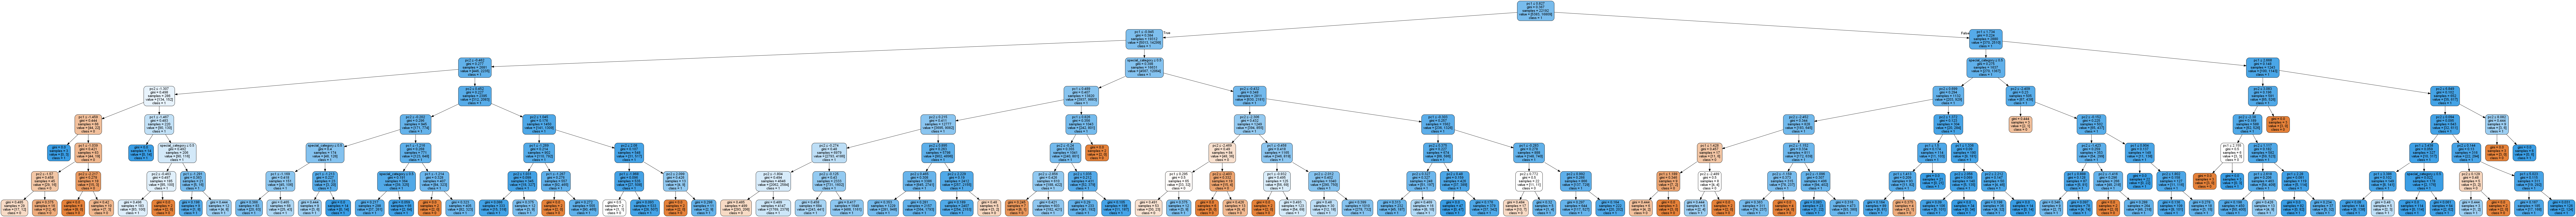

In [38]:
dot_data = StringIO()
feature_cols = ['pc1', 'pc2', 'special_category']
export_graphviz(dt_tuned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('restaurants.png')
Image(graph.create_png())

In [39]:
# Tune hyperparameters in logistic regression classifier using GridSearchCV
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate the GridSearchCV object
grid_lr = GridSearchCV(LogisticRegression(), param_grid, scoring=scoring, cv=5, refit='AUC', return_train_score=True)

# Fit to training data
grid_lr.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(grid_lr.best_params_))
print("Best score is {}".format(grid_lr.best_score_))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.0000000...5, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])},
             pre_dispatch='2*n_jobs', refit

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795}
Best score is 0.6902123540644062


In [18]:
# Tune hyperparameters in KNN classifier using GridSearchCV
# Setup the hyperparameter grid
param_grid = {'n_neighbors': np.arange(1,50)}

# Instantiate the GridSearchCV object
grid_knn = GridSearchCV(KNN(), param_grid, cv=5)

# Fit to training data
grid_knn.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned KNN Parameters: {}".format(grid_knn.best_params_))
print("Best score is {}".format(grid_knn.best_score_))

KeyboardInterrupt: 

In [ ]:
# Instantiate the classifiers
lr = LogisticRegression(C=0.44, random_state=SEED)
knn = KNN(n_neighbors=47)
dt = DecisionTreeClassifier(max_depth = 3, max_features = 4, min_samples_leaf = 1, random_state=SEED)

# Make a list of the classifiers
classifiers = [('Logistic Regression',lr),('K Nearest Neighbors',knn),('Decision Tree',dt)]

for clf_name, clf in classifiers:
    # Fit to training set
    clf.fit(X_train, y_train)
    
    # Predict the labels on the test set
    y_pred_ensemble = clf.predict(X_test)
    
    # Evaluate accuracy of the classifier on the test data
    print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))

In [ ]:
# Instantiate voting classifier
vc = VotingClassifier(estimators=classifiers)

# Fit to training data
vc.fit(X_train, y_train)

# Predict on test data
y_pred_vc = vc.predict(X_test)

# Evaluate the accuracy of voting classifier on test data
accuracy_score(y_test, y_pred_vc)

In [ ]:
# Instantiate a decision tree with tuned parameters
dt_bag = DecisionTreeClassifier(max_depth = 3, max_features = 4, min_samples_leaf = 2, random_state=SEED)

# Instantiate a bagging classifier
bag = BaggingClassifier(base_estimator=dt_bag, n_estimators=50, n_jobs=-1)

# Fit to training set
bag.fit(X_train, y_train)

# Predict on test data
y_pred_bag = bag.predict(X_test)

# Evaluate the accuracy of bagging classifier
accuracy_score(y_test, y_pred_bag)

Using bootstraping provided by the bagging classifier, the decision tree model now provides improved accuracy for predicting whether a restaurant is closed permanently.

In [ ]:
# Instantiate a random forest classifier
rf = RandomForestClassifier(n_estimators=400, max_depth = 3, max_features = 4, min_samples_leaf = 2, random_state=SEED)

# Fit to training data
rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate the accuracy and MSE of random forest classifier on the test set
accuracy_score(y_test, y_pred_rf)
MSE(y_test, y_pred_rf)

The random forest classifier produced similar accuracy as the bagging classifier, both improving on the accuracy of the basic decision tree classifier and the voting classifier. The random forest classifier also has a lower MSE than the previous classifiers.

In [ ]:
# Create series of the features importances and sort the values
importances = pd.Series(rf.feature_importances_, index=['special_category','change_over_time','density','volatility','review_frequency']).sort_values()

# Visualize the ranked importance of the features in a horizontal bar plot
importances.plot(kind='barh', color='lightgreen')
plt.show();

In [ ]:
# Define the parameters grid of random forests
param_grid_rf = {'n_estimators': [100,200,300,400,500],
                 'max_depth': [2,3,4,5],
                 'min_samples_leaf': [0.1,0.2,1,2,3],
                 'max_features': [1,2,3,4,5]}

# Instantiate the GridSearchCV object
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)

# Fit to training data
grid_rf.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(grid_rf.best_params_))
print("Best score is {}".format(grid_rf.best_score_))

In [ ]:
# Extract the best random forest model from grid search
best_rf = grid_rf.best_estimator_

# Predict on test set
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the accuracy and MSE
accuracy_score(y_test, y_pred_best_rf)
MSE(y_test, y_pred_best_rf)

In [ ]:
# Create series of the features importances and sort the values
importances = pd.Series(best_rf.feature_importances_, index=['special_category','change_over_time','density','volatility','review_frequency']).sort_values()

# Visualize the ranked importance of the features in a horizontal bar plot
importances.plot(kind='barh', color='lightgreen')
plt.show();

In [ ]:
# Instantiate a decision tree classifier
dt_adb = DecisionTreeClassifier(max_depth = 3, max_features = 4, min_samples_leaf = 2, random_state=SEED)

# Instantiate a AdaBoost classifier
adb = AdaBoostClassifier(base_estimator=dt_adb, n_estimators=100)

# Fit AdaBoost to training data
adb.fit(X_train, y_train)

# Predict test set probabilities of restaurants that are open
y_pred_adb_proba = adb.predict_proba(X_test)[:,1]

# Evaluate the ROC area under the curve score
auc = roc_auc_score(y_test, y_pred_adb_proba)

In [ ]:
auc

In [ ]:
# Instantiate Gradient Boosting classifier
gb = GradientBoostingClassifier(n_estimators=300, max_depth = 3, max_features = 4, min_samples_leaf = 2, random_state=SEED)

# Fit to training data
gb.fit(X_train, y_train)

# Predict the labels on test data
y_pred_gb = gb.predict(X_test)

# Evaluate the accuracy and MSE
accuracy_score(y_test, y_pred_gb)
MSE(y_test, y_pred_gb)